- żeby konwertować .mp3 do .wav oprócz pydub potrzebny był ffmpeg
    - ffmpeg został pobrany z oficjalnej strony dystrybutora i dodane do PATH

# Setup

In [1]:
# # OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# # OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
from src.data.make_dataset import DataCreator
from src.features.preprocess import create_dataframe, DataPreprocessor, noising 
from src.models.model_setup import gmmhmm, IwrGaussianHMMModel
from src.models.model_selection import Noiser, GridSearch

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
np.random.seed(7)

# Data Preparation

### Dodaj padding do dźwięków

In [35]:
dc = DataCreator()

In [37]:
dc.generate_observations(200)

In [69]:
# sr = 22050
# dc.max_len / sr
# > 1.2384580498866213

1.2384580498866213

# Preprocessing

In [6]:
train_df, test_df, mapper = create_dataframe(how_many=200)

In [7]:
test_df

,path,word,label
0,data\test\up\up_28.wav,up,8.0
1,data\test\left\left_35.wav,left,2.0
2,data\test\up\up_31.wav,up,8.0
3,data\test\off\off_16.wav,off,4.0
4,data\test\up\up_33.wav,up,8.0
...,...,...,...
355,data\test\right\right_7.wav,right,6.0
356,data\test\off\off_29.wav,off,4.0
357,data\test\yes\yes_17.wav,yes,9.0
358,data\test\down\down_17.wav,down,0.0


In [8]:
train_df

,path,word,label
0,data\train\go\go_145.wav,go,1.0
1,data\train\down\down_122.wav,down,0.0
2,data\train\yes\yes_133.wav,yes,9.0
3,data\train\go\go_176.wav,go,1.0
4,data\train\up\up_13.wav,up,8.0
...,...,...,...
1995,data\train\up\up_20.wav,up,8.0
1996,data\train\right\right_163.wav,right,6.0
1997,data\train\up\up_43.wav,up,8.0
1998,data\train\no\no_64.wav,no,3.0


In [6]:
train_dp = DataPreprocessor(train_df)
X_train, y_train = train_dp.mfcc(12, S=0.045, R=0.05)

In [7]:
test_dp = DataPreprocessor(test_df)
X_test, y_test = test_dp.mfcc(12, S=0.045, R=0.05)

In [8]:
X_train.shape

(1000, 12, 25)

In [9]:
X_test.shape

(200, 12, 25)

# Modelling

In [10]:
model = IwrGaussianHMMModel(n_states=6, n_iter=20)

In [11]:
model.fit(X_train, y_train)

In [12]:
model.score(X_train, y_train)

0.951

In [13]:
model.score(X_test, y_test)

0.975

# Noising

Based on the algorithm in:
Timmer, J. and Koenig, M.:
On generating power law noise.

## White noise

In [380]:
y = np.random.normal(0, 1, size=3000)

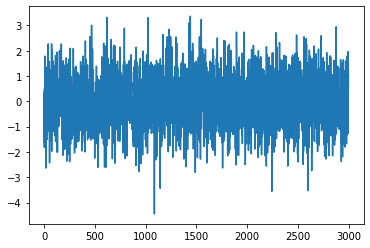

In [381]:
plt.plot(y)

In [382]:
y = cn.powerlaw_psd_gaussian(0, 3000)

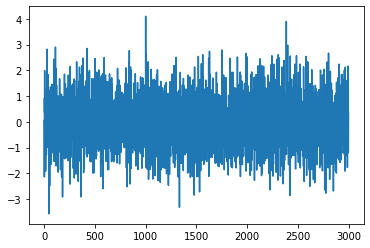

In [383]:
plt.plot(y)

## Pink noise
- szum gaussowaski z beta =1

In [368]:
s = cn.powerlaw_psd_gaussian(1, 3000)

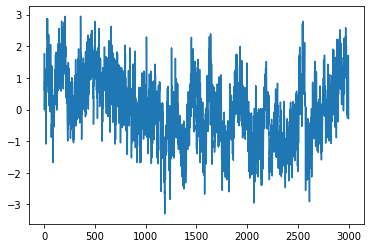

In [371]:
plt.plot(s)

## Szum browna
- szum gaussowski z beta = 2

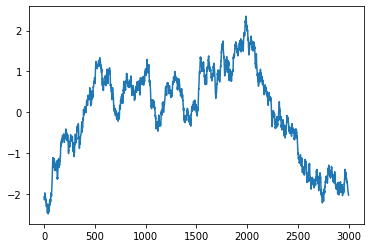

In [372]:
s = cn.powerlaw_psd_gaussian(2, 3000)

plt.plot(s)

## Niebieski szum

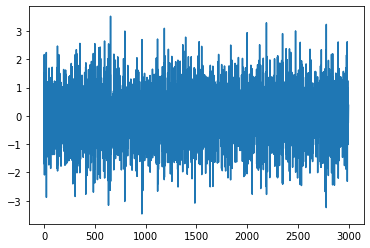

In [387]:
y = cn.powerlaw_psd_gaussian(-2, 3000)

plt.plot(y)

In [388]:
np.std(y)

1.0006774255926991

## Fioletowy szum

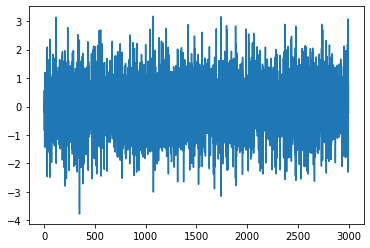

In [384]:
y = cn.powerlaw_psd_gaussian(-1, 3000)

plt.plot(y)

In [385]:
np.std(y)

1.004367523462684

## Code

### Example

In [401]:
y, sr = librosa.load(r'data\train\yes\yes_93.wav')

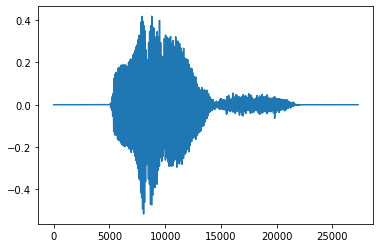

In [394]:
plt.plot(y)

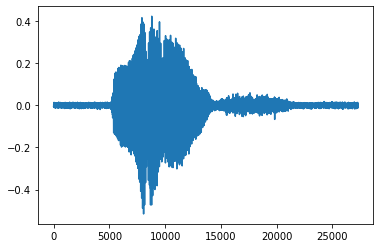

In [396]:
plt.plot(noising(y, 0, 0))

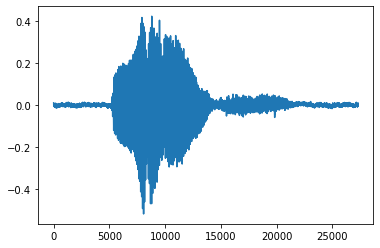

In [397]:
plt.plot(noising(y, 1, 0))

In [402]:
IPython.display.Audio(data=y, rate=sr)

In [420]:
IPython.display.Audio(data=noising(y, 0, 7), rate=sr)

# Results

## Parameters changing

- accents [com.au, com, co.in]<br><br>

- train model with clean/ a bit noised observations<br><br>

    - random horizontal shift [0.1, 0.25, 0.4]
        - random vertical rescaling [0.5, 1, 10]<br><br>

    - how many training examples - [20, 100, 200]<br><br>

        - M - number of mfcc - [13]
        - R - [0.025, 0.04] 
        - S - [0.01, 0.03, 0.05]<br><br>

    - crosswalidacja k=5<br><br>

    - number of iterations - [15, 30, 50]
    - n hidden states - [4, 6, 12]<br><br>
    
    - different nosies [-2, -1, 0, 1, 2]
    - different SNR [-3, 0, 3, 9] <br><br>

    - different metrics [acc, prec, rec, f1]

- znajdź dobre jak jeset dobrze, a później udziwniaj
- pamiętaj nie wszystko jest wykorzystywane do trenowania modeli, ale głównie do testu
- random shifting dawać dopiero po wytrenowaniu

- confusion matrix
- boxplots
- tables

## Choosing model params

In [12]:
params = {'n_samples':[20, 100, 200],
          'n_mfcc':[13],
          'hop_wins':[0.01, 0.03, 0.05],
          'len_wins':[0.025, 0.04],
          'n_iters':[15, 30, 50],
          'n_hiddens':[4, 6, 12]}

gs = GridSearch(random_state=7)

In [29]:
results = gs.grid_search_model(params, k=5)

Iteration 1/162.
Iteration 5/162.
Iteration 10/162.
Iteration 15/162.
Iteration 20/162.
Iteration 25/162.
Iteration 30/162.
Iteration 35/162.
Iteration 40/162.
Iteration 45/162.
Iteration 50/162.
Iteration 55/162.
Iteration 60/162.
Iteration 65/162.
Iteration 70/162.
Iteration 75/162.
Iteration 80/162.
Iteration 85/162.
Iteration 90/162.
Iteration 95/162.
Iteration 100/162.
Iteration 105/162.
Iteration 110/162.
Iteration 115/162.
Iteration 120/162.
Iteration 125/162.
Iteration 130/162.
Iteration 135/162.
Iteration 140/162.
Iteration 145/162.
Iteration 150/162.
Iteration 155/162.
Iteration 160/162.


In [31]:
# results.to_csv(r'results\result_choose_model_params.csv')

## Adding randomness

- train model with clean/ a bit noised observations<br><br>

    - random horizontal shift [0.1, 0.25, 0.4]
    - random vertical rescaling [0.5, 1, 10]<br><br>

    - number of iterations - [15, 30, 50]
    - n hidden states - [4, 6, 12]<br><br>
    
    - different nosies [-2, -1, 0, 1, 2]
    - different SNR [-3, 0, 3, 9] <br><br>

In [67]:
params = {
    'random_horizontal_shift': [0.1, 0.25, 0.4],
    'random_vertical_scaling': [0.5, 1, 10],
    'n_iter' : [15, 30, 50],
    'n_hiddens': [5, 6, 7]
}

gs = GridSearch(random_state=7)

results = gs.grid_search_randomness(params)

D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:32: RuntimeWarning: invalid value encountered in true_divide
  alpha[:, t] /= alpha_sum
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:33: RuntimeWarning: divide by zero encountered in log
  log_likelihood = log_likelihood + np.log(alpha_sum)
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:44: RuntimeWarning: invalid value encountered in true_divide
  beta[:, t] /= np.sum(beta[:, t])
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:32: RuntimeWarning: invalid value encountered in true_divide
  alpha[:, t] /= alpha_sum
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:33: RuntimeWarning: divide by zero encountered in log
  log_likelihood = log_likelihood + np.log(alpha_sum)
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:44: RuntimeWarning: invalid value encountered in true_divide
  beta[:, t] /= np.sum(beta[:, t])
D:\studia\jupyter notebook\inzyn

D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:32: RuntimeWarning: invalid value encountered in true_divide
  alpha[:, t] /= alpha_sum
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:33: RuntimeWarning: divide by zero encountered in log
  log_likelihood = log_likelihood + np.log(alpha_sum)
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:32: RuntimeWarning: invalid value encountered in true_divide
  alpha[:, t] /= alpha_sum
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:33: RuntimeWarning: divide by zero encountered in log
  log_likelihood = log_likelihood + np.log(alpha_sum)
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:32: RuntimeWarning: invalid value encountered in true_divide
  alpha[:, t] /= alpha_sum
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:33: RuntimeWarning: divide by zero encountered in log
  log_likelihood = log_likelihood + np.log(alpha_sum)
D:\studia\jupyter notebook\i

D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:32: RuntimeWarning: invalid value encountered in true_divide
  alpha[:, t] /= alpha_sum
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:33: RuntimeWarning: divide by zero encountered in log
  log_likelihood = log_likelihood + np.log(alpha_sum)
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:64: RuntimeWarning: divide by zero encountered in true_divide
  return (x + (x == 0)) / np.sum(x)
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:69: RuntimeWarning: invalid value encountered in true_divide
  return (x + (x == 0)) / sum_of_rows[:, np.newaxis]
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:32: RuntimeWarning: invalid value encountered in true_divide
  alpha[:, t] /= alpha_sum
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:33: RuntimeWarning: divide by zero encountered in log
  log_likelihood = log_likelihood + np.log(alpha_sum)
D:\studia\ju

D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:32: RuntimeWarning: invalid value encountered in true_divide
  alpha[:, t] /= alpha_sum
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:33: RuntimeWarning: divide by zero encountered in log
  log_likelihood = log_likelihood + np.log(alpha_sum)
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:44: RuntimeWarning: invalid value encountered in true_divide
  beta[:, t] /= np.sum(beta[:, t])
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:64: RuntimeWarning: divide by zero encountered in true_divide
  return (x + (x == 0)) / np.sum(x)
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:69: RuntimeWarning: invalid value encountered in true_divide
  return (x + (x == 0)) / sum_of_rows[:, np.newaxis]
D:\studia\jupyter notebook\inzynierka\src\models\model_setup.py:32: RuntimeWarning: invalid value encountered in true_divide
  alpha[:, t] /= alpha_sum
D:\studia\jupyter notebo

In [68]:
# results.to_csv(r'results\result_randomness.csv')

## Noising

In [123]:
params = {
    'beta': [-2, -1, 0, 1, 2],
    'SNR': [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'n_iters' : [15],
    'n_hiddens': [6]
}

In [99]:
noise_gs = Noiser(random_state=7)

In [100]:
results = noise_gs.noise_hmm_results(params)

Iteration 1/60.
Iteration 5/60.
Iteration 10/60.
Iteration 15/60.
Iteration 20/60.
Iteration 25/60.
Iteration 30/60.
Iteration 35/60.
Iteration 40/60.
Iteration 45/60.
Iteration 50/60.
Iteration 55/60.
Iteration 60/60.


In [101]:
# results.to_csv(r'results\result_noise.csv')

In [106]:
results = noise_gs.noise_hmm_results(params, train_on_noise=True, beta_noise=0, snr_noise=5)

Iteration 1/60.
Iteration 5/60.
Iteration 10/60.
Iteration 15/60.
Iteration 20/60.
Iteration 25/60.
Iteration 30/60.
Iteration 35/60.
Iteration 40/60.
Iteration 45/60.
Iteration 50/60.
Iteration 55/60.
Iteration 60/60.


In [107]:
results.to_csv(r'results\result_noise_on_noise.csv')

## Noise to noise

In [12]:
params = {
    'beta': [-2, -1, 0, 1, 2],
    'SNR': [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'chosen_snr': [5, 6, 7, 8, 9], 
    'n_iters' : [15],
    'n_hiddens': [6]
}

noise_gs = Noiser(random_state=7)
best, cost = noise_gs.best_noise_on_noise_grid_search(params)

Training base result...
Iteration 0/1500.
Iteration 60/1500. Evaluation time: 12 min 37.87 s
Iteration 120/1500. Evaluation time: 12 min 44.58 s
Iteration 180/1500. Evaluation time: 11 min 34.16 s
Iteration 240/1500. Evaluation time: 11 min 28.92 s
Iteration 300/1500. Evaluation time: 11 min 24.34 s
Iteration 360/1500. Evaluation time: 11 min 27.97 s
Iteration 420/1500. Evaluation time: 11 min 30.47 s
Iteration 480/1500. Evaluation time: 11 min 31.47 s
Iteration 540/1500. Evaluation time: 11 min 29.73 s
Iteration 600/1500. Evaluation time: 11 min 27.12 s
Iteration 660/1500. Evaluation time: 11 min 27.20 s
Iteration 720/1500. Evaluation time: 11 min 47.52 s
Iteration 780/1500. Evaluation time: 11 min 40.21 s
Iteration 840/1500. Evaluation time: 12 min 1.23 s
Iteration 900/1500. Evaluation time: 11 min 23.76 s
Iteration 960/1500. Evaluation time: 11 min 38.72 s
Iteration 1020/1500. Evaluation time: 11 min 58.57 s
Iteration 1080/1500. Evaluation time: 11 min 31.12 s
Iteration 1140/1500. E

In [13]:
cost

beta_-2_snr_5    36
beta_-2_snr_6    36
beta_-2_snr_7    38
beta_-2_snr_8    39
beta_-2_snr_9    46
beta_-1_snr_5    36
beta_-1_snr_6    36
beta_-1_snr_7    37
beta_-1_snr_8    43
beta_-1_snr_9    38
beta_0_snr_5     39
beta_0_snr_6     27
beta_0_snr_7     38
beta_0_snr_8     38
beta_0_snr_9     37
beta_1_snr_5     20
beta_1_snr_6     30
beta_1_snr_7     26
beta_1_snr_8     29
beta_1_snr_9     30
beta_2_snr_5     18
beta_2_snr_6     19
beta_2_snr_7     20
beta_2_snr_8     26
beta_2_snr_9     20
dtype: int64

In [14]:
best

beta_-2_snr_9    46
dtype: int64

In [15]:
# cost.to_csv(r'results\cost_search_noise_on_noise.csv')

In [17]:
params = {
    'beta': [-2],
    'SNR': [-1, 0],
    'chosen_snr': [6], 
    'n_iters' : [15],
    'n_hiddens': [6]
}

noise_gs = Noiser(random_state=7)

noise_gs.best_noise_on_noise_grid_search(params)

Training base result...
Iteration 0/2.
Iteration 2/2. Evaluation time: 3 min 38.54 s


(beta_-2_snr_6    2
 dtype: int64,
 beta_-2_snr_6    2
 dtype: int64)

In [18]:
params = {
    'random_horizontal_shift': [0.1],
    'random_vertical_scaling': [1],
    'n_iter' : [15],
    'n_hiddens': [7]
}

gs = GridSearch(random_state=7)

results = gs.grid_search_randomness(params)

In [19]:
gs.create_random_datasets(params)

['data']

In [20]:
params = {'n_samples':[20],
          'n_mfcc':[13],
          'hop_wins':[0.01],
          'len_wins':[0.025],
          'n_iters':[15],
          'n_hiddens':[4]}

gs = GridSearch(random_state=7)
results = gs.grid_search_model(params, k=5)

Iteration 1/1.
